In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [45]:
df = pd.read_csv('data.csv').replace('-', np.NaN).astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   t       2000 non-null   float64
 1   x       819 non-null    float64
 2   y       827 non-null    float64
dtypes: float64(3)
memory usage: 47.0 KB


In [47]:
df.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 327 entries, 4 to 1987
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   t       327 non-null    float64
 1   x       327 non-null    float64
 2   y       327 non-null    float64
dtypes: float64(3)
memory usage: 10.2 KB


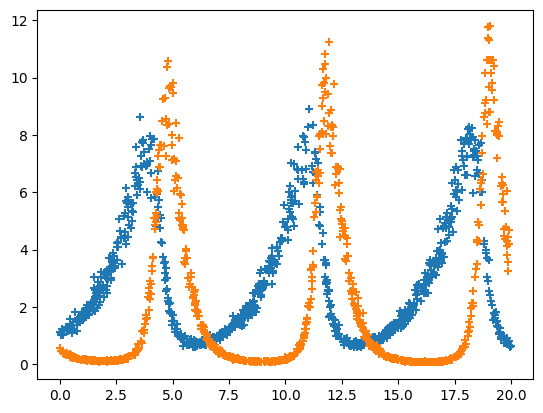

In [3]:
plt.scatter(x=df.t, y=df.x, marker='+')
plt.scatter(x=df.t, y=df.y, marker='+')
plt.show()

In [4]:
df_filled = df.interpolate(limit_direction='both')
df_filled

,t,x,y
0,0.00,1.115912,0.575905
1,0.01,1.115912,0.551311
2,0.02,1.115912,0.526716
3,0.03,1.060697,0.502121
4,0.04,1.005483,0.477527
...,...,...,...
1995,19.95,0.611707,4.186361
1996,19.96,0.615469,4.186361
1997,19.97,0.619231,4.186361
1998,19.98,0.622993,4.186361


<AxesSubplot:xlabel='t'>

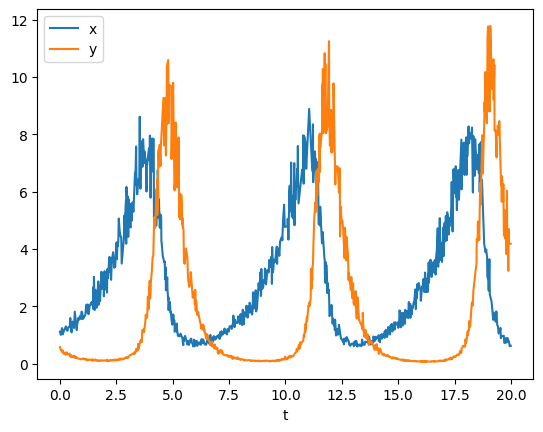

In [5]:
df_filled.plot(x='t', y=['x', 'y'])

# Linear NN

In [3]:
class Net(nn.Module):
    '''Model to regress 2d time series values given scalar input.'''
    def __init__(self):
        super(Net, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(1, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
        )

    def forward(self, x):
        out = self.linear_relu_stack(x)
        return out

In [4]:
class TimeSeriesDataset(torch.utils.data.Dataset):

    def __init__(self, csv_file):
        self.df = pd.read_csv(csv_file).replace('-', np.NaN).astype(float)
        self.df_filled = self.df.interpolate(limit_direction='both')
        self.X = torch.tensor(self.df_filled[['t']].values)
        self.y = torch.tensor(self.df_filled[['x', 'y']].values)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx].float(), self.y[idx].float()

In [88]:
train = TimeSeriesDataset('data.csv')
X, y = train[0]
X.shape, y.shape

(torch.Size([1]), torch.Size([2]))

In [69]:
trainloader = torch.utils.data.DataLoader(train, batch_size=5, shuffle=True)

for i, data in enumerate(trainloader, 0):
    inputs, labels = data
    print(inputs)
    print(inputs.shape)
    print(labels)
    print(labels.shape)
    break

tensor([[18.6700],
        [17.7000],
        [19.9100],
        [16.0900],
        [13.5800]])
torch.Size([5, 1])
tensor([[6.3407, 5.5559],
        [5.9110, 0.3260],
        [0.7463, 4.1864],
        [2.6787, 0.0855],
        [0.7556, 0.9085]])
torch.Size([5, 2])


In [39]:
BATCH_SIZE = 16

dataset = TimeSeriesDataset('data.csv')
trainloader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=True)

# def loss_fn(outputs, labels):
#   #TODO

learning_rate = 0.001

loss_fn = nn.MSELoss()

net = Net()

# if torch.backends.mps.is_available():
#     device = torch.device('mps')
#     net.to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [6]:
sum(p.numel() for p in net.parameters())

175650

In [40]:
for epoch in range(300):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        # inputs, labels = data[0].to(device), data[1].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:    # print every 20 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 20))
            running_loss = 0.0

print('Finished Training')

[1,    20] loss: 8.080
[1,    40] loss: 7.398
[1,    60] loss: 7.728
[1,    80] loss: 7.589
[1,   100] loss: 7.030
[1,   120] loss: 6.841
[2,    20] loss: 6.232
[2,    40] loss: 6.761
[2,    60] loss: 5.947
[2,    80] loss: 6.018
[2,   100] loss: 5.660
[2,   120] loss: 5.903
[3,    20] loss: 5.349
[3,    40] loss: 4.993
[3,    60] loss: 5.219
[3,    80] loss: 5.506
[3,   100] loss: 5.369
[3,   120] loss: 4.902
[4,    20] loss: 5.549
[4,    40] loss: 4.687
[4,    60] loss: 4.755
[4,    80] loss: 4.892
[4,   100] loss: 4.472
[4,   120] loss: 4.453
[5,    20] loss: 4.482
[5,    40] loss: 4.214
[5,    60] loss: 4.552
[5,    80] loss: 4.046
[5,   100] loss: 5.177
[5,   120] loss: 4.959
[6,    20] loss: 4.833
[6,    40] loss: 5.700
[6,    60] loss: 4.111
[6,    80] loss: 4.904
[6,   100] loss: 4.749
[6,   120] loss: 4.864
[7,    20] loss: 4.732
[7,    40] loss: 4.506
[7,    60] loss: 4.236
[7,    80] loss: 4.542
[7,   100] loss: 4.996
[7,   120] loss: 4.422
[8,    20] loss: 4.562
[8,    40] 

In [41]:
# Plot results to validate training
def predict(data_loader, model):
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    return output

predictloader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=False)

pred = predict(predictloader, net)
pred

tensor([[1.1205, 0.6111],
        [1.1206, 0.6045],
        [1.1209, 0.5978],
        ...,
        [0.6968, 5.3241],
        [0.6958, 5.3280],
        [0.6948, 5.3318]])

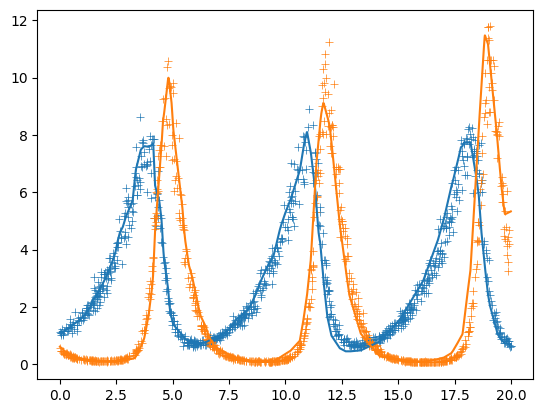

In [42]:
plt.scatter(x=df.t, y=df.x, marker='+', linewidths=.5)
plt.scatter(x=df.t, y=df.y, marker='+', linewidths=.5)
plt.plot(df.t, pred)
plt.show()

# Time Series LSTM

In [39]:
class Net(nn.Module):
    '''Model to regress 2d time series values given scalar input.'''
    def __init__(self):
        super(Net, self).__init__()
        self.num_layers = 1
        self.hidden_units = 16
        
        self.lstm = nn.LSTM(
            input_size=1,
            hidden_size=self.hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )
        
        self.linear = nn.Linear(in_features=self.hidden_units, out_features=2)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        
        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0])  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [34]:
class TimeSeriesDataset(torch.utils.data.Dataset):

    def __init__(self, csv_file):
        self.df = pd.read_csv(csv_file).replace('-', np.NaN).astype(float)
        self.df_filled = self.df.interpolate(limit_direction='both')
        self.X = torch.tensor(self.df_filled[['t']].values)
        self.y = torch.tensor(self.df_filled[['x', 'y']].values)
        self.seq_l = 7

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        if idx >= self.seq_l:
            i_start = idx - self.seq_l
            X = self.X[i_start:idx]
        else:
            padding = self.X[0].repeat(self.seq_l - idx, 1)
            X = self.X[0:idx]
            X = torch.cat((padding, X), 0)

        return X.float(), self.y[idx].float()

In [10]:
train = TimeSeriesDataset('data.csv')
X, y = train[4]
X, y

(tensor([[0.0000],
         [0.0000],
         [0.0100],
         [0.0200],
         [0.0300]]),
 tensor([1.0055, 0.4775]))

In [11]:
df_filled.head(9)

,t,x,y
0,0.00,1.115912,0.575905
1,0.01,1.115912,0.551311
2,0.02,1.115912,0.526716
3,0.03,1.060697,0.502121
4,0.04,1.005483,0.477527
5,0.05,1.053657,0.468851
6,0.06,1.101832,0.460175
7,0.07,1.074546,0.465963
8,0.08,1.157007,0.471751


In [12]:
trainloader = torch.utils.data.DataLoader(train, batch_size=5, shuffle=True)

for i, data in enumerate(trainloader, 0):
    inputs, labels = data
    print(inputs)
    print(inputs.shape)
    print(labels)
    print(labels.shape)
    break

tensor([[[16.3700],
         [16.3800],
         [16.3900],
         [16.4000],
         [16.4100]],

        [[ 2.9600],
         [ 2.9700],
         [ 2.9800],
         [ 2.9900],
         [ 3.0000]],

        [[ 8.4900],
         [ 8.5000],
         [ 8.5100],
         [ 8.5200],
         [ 8.5300]],

        [[10.0500],
         [10.0600],
         [10.0700],
         [10.0800],
         [10.0900]],

        [[10.4600],
         [10.4700],
         [10.4800],
         [10.4900],
         [10.5000]]])
torch.Size([5, 5, 1])
tensor([[3.5674, 0.0676],
        [5.1455, 0.1950],
        [1.8488, 0.1018],
        [5.0525, 0.1898],
        [6.6634, 0.4378]])
torch.Size([5, 2])


In [52]:
BATCH_SIZE = 8

dataset = TimeSeriesDataset('data.csv')
trainloader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=True)

# def loss_fn(outputs, labels):
#   #TODO

learning_rate = 0.001

loss_fn = nn.MSELoss()

net = Net()

# if torch.backends.mps.is_available():
#     device = torch.device('mps')
#     net.to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [53]:
for epoch in range(300):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        # inputs, labels = data[0].to(device), data[1].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:    # print every 20 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 20))
            running_loss = 0.0

print('Finished Training')

[1,    20] loss: 11.149
[1,    40] loss: 13.344
[1,    60] loss: 10.721
[1,    80] loss: 10.766
[1,   100] loss: 7.774
[1,   120] loss: 8.039
[1,   140] loss: 6.730
[1,   160] loss: 6.774
[1,   180] loss: 7.615
[1,   200] loss: 5.856
[1,   220] loss: 5.785
[1,   240] loss: 6.054
[2,    20] loss: 7.180
[2,    40] loss: 6.624
[2,    60] loss: 6.135
[2,    80] loss: 7.034
[2,   100] loss: 6.751
[2,   120] loss: 6.805
[2,   140] loss: 5.725
[2,   160] loss: 6.351
[2,   180] loss: 5.991
[2,   200] loss: 6.941
[2,   220] loss: 5.937
[2,   240] loss: 6.283
[3,    20] loss: 6.608
[3,    40] loss: 7.099
[3,    60] loss: 6.692
[3,    80] loss: 6.243
[3,   100] loss: 6.024
[3,   120] loss: 6.033
[3,   140] loss: 6.574
[3,   160] loss: 6.770
[3,   180] loss: 6.271
[3,   200] loss: 5.607
[3,   220] loss: 5.379
[3,   240] loss: 5.690
[4,    20] loss: 6.512
[4,    40] loss: 5.684
[4,    60] loss: 5.618
[4,    80] loss: 6.167
[4,   100] loss: 5.671
[4,   120] loss: 5.955
[4,   140] loss: 5.716
[4,   1

In [54]:
# Plot results to validate training
def predict(data_loader, model):
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    return output

predictloader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=False)

pred = predict(predictloader, net)
pred

tensor([[1.0787, 0.4860],
        [1.0787, 0.4860],
        [1.0809, 0.4893],
        ...,
        [0.4740, 4.0157],
        [0.4636, 3.9767],
        [0.4532, 3.9387]])

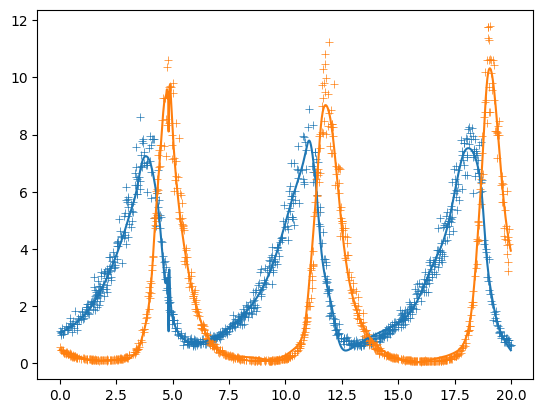

In [55]:
plt.scatter(x=df.t, y=df.x, marker='+', linewidths=.5)
plt.scatter(x=df.t, y=df.y, marker='+', linewidths=.5)
plt.plot(df.t, pred)
plt.show()

## Questions
Please answer the questions about the exercise below as a text cell. A few sentences answer per question is enough, no need to write a long essay.
  
- a) Roughly, how many parameters does the neural network you defined above have? How did you estimate that number?

There are 175,650 parameters. Each layer is fully connected (INPUT_SIZE * OUTPUT_SIZE number of connections) with a constant term for each output node (OUTPUT_SIZE number of constants), so the formula for each layer is (INPUT_SIZE * OUTPUT_SIZE) + OUTPUT_SIZE.

(1 input * 512 output) + 512 constants<br>
(512 input * 256 output) + 256 constants<br>
(256 input * 128 output) + 128 constants<br>
(128 input * 64 output) + 64 constants<br>
(64 input * 32 output) + 32 constants<br>
(32 input * 2 output) + 2 constants<br>
175,650 total parameters

- b) How does changing the batch size affect the optimization procedure?

Within one epoch, the model adjusts the weights on the parameters after every batch. With small batches, the model will be able to adjust its trained weights faster and achieve better fitting with less epochs. However, there will be higher fluctuations in the running loss since smaller batches increase the chances of a batch performing poorly or not being representative of the entire sample size. For 300 epochs with a small batch size, there might be significant overfitting.

With larger batch sizes, the loss decreases at a slower rate, but the high number of samples per batch should allow higher chance for better representation of the sample. However, since the weights will be adjusted less frequently than with small batch sizes, if there are insufficient epochs, there may be underfitting.

In terms of training time and performance, especially without a GPU for parallel processing, smaller batches will take much longer than larger batches.

- c) What optimizer did you choose and why? Explain its most important hyperparameters.

Adam is a 'catch-all' optimizer, that tries to combine to preferred features of other optimizers like AdaGrad and RMSProp. Adam has faster computation time and requires less tuning, so it has become the default for benchmarks and is usually a good place to start when training new models from scratch. Adam allows adjustment of two beta coefficients, which represent the decay rate of the average of the gradients. The learning rate can be adjusted and a lamba coefficient can be included to introduce L2 regularization.

In the case of training this model, the default learning rate was chosen at 0.001. A learning rate too high allowed faster gradient descent, but as the gradient flattened, the model was unable to zero in on the minimum. A learning rate too low mean the descent was too slow and risked getting stuck in a local minimum. For this training with 300 epochs, the default rate of 0.001 worked well.

- d) What difficulties did you face when processing the dataset? How did you resolve them?

For the 2000 time points in the dataset, both x and y were missing just under 1200 points each (~60%). Furthermore, dropping data points that were missing either x or y left us with only 327 points (~16%). Instead, the pandas interpolate strategy was used to interpolate missing data points between existing data points.

- e) How did you find the hyperparameters that gave you the best result? What would you have done if you had more time?

Through running the training a few times and adjusting the parameters through some commonly used values to start with. For instance, the dataset and NN was small enough to test with batch sizes of 4, 8, 16, 32, 64, and 128. Learning rates of 0.01, 0.001, and 0.0001 were also tested to see their effects on training. If given more time, we could perform a grid search on the Adam optimizer parameters for the two beta coefficients, learning rate, and lamba coefficient to find the optimal combination of parameters.

- f) In this exercise, we trained an MLP to regress the data from a single time point. This corresponds to assuming the source function is markovian. What would we do differently if the function under study were non-markovian?

If the model was non-markovian, we can use a model that can handle short/long-term memory, such as an LSTM. The dataset would need to be prepared where the input is a sequence of consecutive time points, and the x, y output would be that of the next following time point. A single-layer LSTM is also created below as a test.

- g) In this exercise, we did not check for overfitting. How would you change the code above to test for that possibility?

By holding a portion of the dataset as validation (20% standard) and adding a validation step to the training process. Then, the loss curves can be plotted to observe the convergence between the training and validation curves. If the training loss is small but the validation loss is large, then the model has most likely overfitted and cannot generalize to unseen data. If the two losses converge relatively closely and are comparable, then the model may perform decently in predicting unseen data.

In [ ]:
nn.Linear(1, 512),
nn.ReLU(),
nn.Linear(512, 256),
nn.ReLU(),
nn.Linear(256, 128),
nn.ReLU(),
nn.Linear(128, 64),
nn.ReLU(),
nn.Linear(64, 32),
nn.ReLU(),
nn.Linear(32, 2),

In [1]:
1*512+512 + 512*256+256 + 256*128+128 + 128*64+64 + 64*32+32 + 32*2+2

175650